<h1><font color="#113D68" size=6>Deep Learning con Python y Keras</font></h1>

<h1><font color="#113D68" size=5>Parte 7. Conceptos avanzados</font></h1>

<h1><font color="#113D68" size=4>2. Transfer Learning</font></h1>

<br><br>
<div style="text-align: right">
<font color="#113D68" size=3>Manuel Castillo Cara</font><br>

</div>

---

<a id="indice"></a>
<h2><font color="#004D7F" size=5>Licencia</font></h2>

<p><small><small>Copyright 2024 Manuel Castillo Cara.</p>
<p><small><small> Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at </p>
<p><small><small> <a href="https://www.apache.org/licenses/LICENSE-2.0">https://www.apache.org/licenses/LICENSE-2.0</a> </p>
<p><small><small> Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License. </p>
    
---

---

<a id="indice"></a>
<h2><font color="#004D7F" size=6>Índice</font></h2>

* [1. Definición, consejos y problemas](#section1)
    * [1.1. Ejemplo](#section12)
    * [1.2. Finnetunning](#section12)
    * [1.3. Transfer Learning](#section13)
* [2. Dataset: Flickr Style](#section2)
    * [2.1. Preparación del dataset](#section21)
    * [2.2. Cargando una red pre-entrenada](#section22)
* [3. MobileNet](#section3)
    * [3.1. Cargar la red](#section32)
    * [3.2. Uso de iteradores](#section32)
    * [3.3. Predicciones con el modelo base](#section33)
* [4. VGG16](#section4)
    * [4.1. Cargar la red](#section42)
    * [4.2. Uso de iteradores](#section42)
    * [4.3. Predicciones con el modelo base](#section43)
* [6. Finetuning](#section6)
    * [6.1. Cargar la red](#section61)
    * [6.2. Añadir capas a la red](#section62)
    * [6.3. Uso de iteradores](#section63)
    * [6.4. Actualización de pesos](#section64)
    * [6.5. Resultados del modelo](#section65)

<a id="section1"></a>
# <font color="#004D7F" size=6> 1. Definición, consejos y problemas</font>

En prácticas anteriores ya hemos visto algunos conceptos básicos sobre como crear nuestras propias redes neuronales. Durante el desarrollo de las mismas habréis observado que conforme va aumentando la complejidad de la red, asi como el tamaño de nuestros datos, los resultados mejoran, a costa del tiempo de entrenamiento.

Sin embargo, ¿qué ocurre cuando no disponemos de datos suficientes o de los recursos necesarios? ¿Es posible utilizar deep learning?
1. Si la cantidad de datos que tenemos es pequeña, entrenar una red neuronal es una tarea complicada. 
2. Si reducimos el tamaño de la red, los resultados que obtengamos pueden que no sean del todo satisfactorios, ya que se va a tratar de un modelo relativamente simple. 
3. Si la red es demasiado grande, los pesos no se ajustarán adecuadamente con los pocos datos de entrenamiento y puede que incluso sobreajustemos a dicha información.

Otra de las limitaciones de las redes neuronales son los tiempos de entrenamiento. Cuando contamos con suficientes datos como para entrenar una red, podemos permitirnos aumentar el tamaño de esta. Sin embargo, esto aumenta el tiempo de los procesos `forward` y `backward` y la complejidad para ajustar los hiperparámetros. 

Por todos estos motivos surge el **Transfer Learning**, donde las redes neuronales aprendidas en problemas en los que hay más disponibilidad de datos se utilizan para resolver otros problemas para los que no fueron diseñadas.

<a id="section11"></a>
# <font color="#004D7F" size=5> 1.1. Ejemplo</font>

Un ejemplo de esto es AlexNet, representada en la imagen, que aprende propiedades de las imágenes que van desde lo más general en las primeras capas hasta las 1.000 etiquetas en su última capa, que indican muy concretamente un objeto identificado en la imagen. 

Durante el proceso `forward` no sólo obtenemos las probabilidades de la última capa, si no que en todas las demás capas se generan una **serie de activaciones** que se pueden interpretar como un conjunto de características que describen la imagen. Estas características pueden utilizarse directamente para entrenar otros modelos como por ejemplo un regresor lineal, un arból de decisión, etc.


<img src="img/AlexNet-CNN.png" width="550">

<a id="section12"></a>
# <font color="#004D7F" size=5> 1.2. Finnetunning</font>

Este concepto consiste en el entrenamiento parcial de redes ya entrenadas, es decir, es posible editar la estructura de parte de una red neural que ya ha sido entrenada y aprender nuevos pesos sólo para las capas modificadas. 

Esto reduce mucho el tiempo de entrenamiento y la cantidad de imágenes necesarias. Volviendo al caso de AlexNet, es posible eliminar la última capa con la salida de 1.000 etiquetas y añadir una nueva capa con la salida de nuestro problema.

<img src="img/finetunning.png" width="550">

<a id="section13"></a>
# <font color="#004D7F" size=5> 1.3. Transfer Learning</font>

En los últimos años, el **Transfer Learning** ha permitido poder utilizar el conocimiento generado en redes neuronales entrenadas con grandes bases de datos. Además, los resultados obtenidos de estas técnicas han superado en muchos problemas el estado del arte y es un area de investigación fuertemente activa. Gracias a esto, se han desarrollado una serie de pautas que, dependiendo de la cantidad de datos del problema y de su similitud con los datos de la red entrenada, nos indicarán que estrategia de Transfer Learning es más adecuada:


|  | **Problemas similares** | **Problemas diferentes** |
| --- | --- | --- |
| **Pocos datos** | Extraer características de las últimas capas y utilizarlas en otros modelos | El peor escenario, se puede probar a obtener características de capas previas a las últimas y utilizarlas en otros modelos |
| **Nº medio de datos** | Finetunning de pocas capas | Finetunning de muchas capas |

En esta práctica vamos a ver como obtener las activaciones que provoca el paso `forward` y como utilizar dicha información para entrenar otros modelos con SciKit. También vamos a ver como realizar finetunning, para utilizar algunas de las redes neuronales más famosas en nuestros problemas.

In [18]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage

%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Establecemos una semilla para numpy y tensorflow para poder reproducir la ejecución y los resultados
SEED = 1000
np.random.seed(SEED)
tf.random.set_seed(SEED)

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section2"></a>
# <font color="#004D7F" size=6>2. Dataset: Flickr Style</font>

Esta base de datos se basa en un conjunto de imágenes de Flickr etiquetadas con un estilo fotográfico. La base de datos original consta de 80K imágenes y 20 estilos diferentes. 

En esta práctica vamos a trabajar con un subconjunto de 2K imágenes de 5 estilos diferentes. Esto se ha hecho para que nos de tiempo a ver todos los conceptos en esta la práctica y poder trabajar tanto en la **extracción de características como en el `finetuning`**. Sin embargo, es posible resolver el problema con el conjunto total de imágenes y algo de paciencia. 

Entrenar una red desde 0 para este problema con 80K imágenes puede no ser suficiente y seguramente los resultados sean peores que con las técnicas de Transfer Learning. Recordad que ImageNet está formada por 1,2M de imágenes.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
Más información de esta base de datos [Flickr](http://sergeykarayev.com/files/1311.3715v3.pdf)

In [15]:
# Instalar aplicación de descarga
#!pip install gdown

In [17]:
import gdown
!gdown --id 1uaOwnmnJX67DKsLz5tzGWB6KUKkh99UJ
!unzip -q flickr_style.zip
!mkdir data
!mv flickr_style data/

Downloading...
From: https://drive.google.com/uc?id=1-xb41WL8so6GSBFvp30enTKoNhwI84eY
To: /home/manwest/Documentos/Jupyter/Deep Learning Keras/Parte 7. Adicional/7.2. Transfer Learning/flickr_style.zip
178MB [02:38, 1.12MB/s] 


<a id="section21"></a>
# <font color="#004D7F" size=5>2.1. Preparación del dataset</font>

A continuación vamos a ver la base de datos y la vamos a preparar para su uso en Keras.

In [21]:
from sklearn.model_selection import train_test_split

STYLE_NUM_LABELS = 5
# obtenemos el nombre de las primeras etiquetas seleccionadas
style_label_file = 'https://raw.githubusercontent.com/BVLC/caffe/master/examples/finetune_flickr_style/style_names.txt'
style_labels = list(np.loadtxt(style_label_file, str, delimiter='\n'))
if STYLE_NUM_LABELS > 0:
    style_labels = style_labels[:STYLE_NUM_LABELS]

train_valid_frame = pd.read_csv('data/flickr_style/train.txt', sep=" ", header=None)
train_valid_frame.columns = ['files','lab_idx']
train_valid_frame['labels'] = train_valid_frame['lab_idx'].map({i:j for i,j in enumerate(style_labels)})

train_frame, valid_frame = train_test_split(
    train_valid_frame, test_size=0.2, random_state=SEED, stratify=train_valid_frame['labels'])

test_frame = pd.read_csv('data/flickr_style/test.txt', sep=" ", header=None)
test_frame.columns = ['files','lab_idx']
test_frame['labels'] = test_frame['lab_idx'].map({i:j for i,j in enumerate(style_labels)})

Echamos un vistazo a algunas imágenes

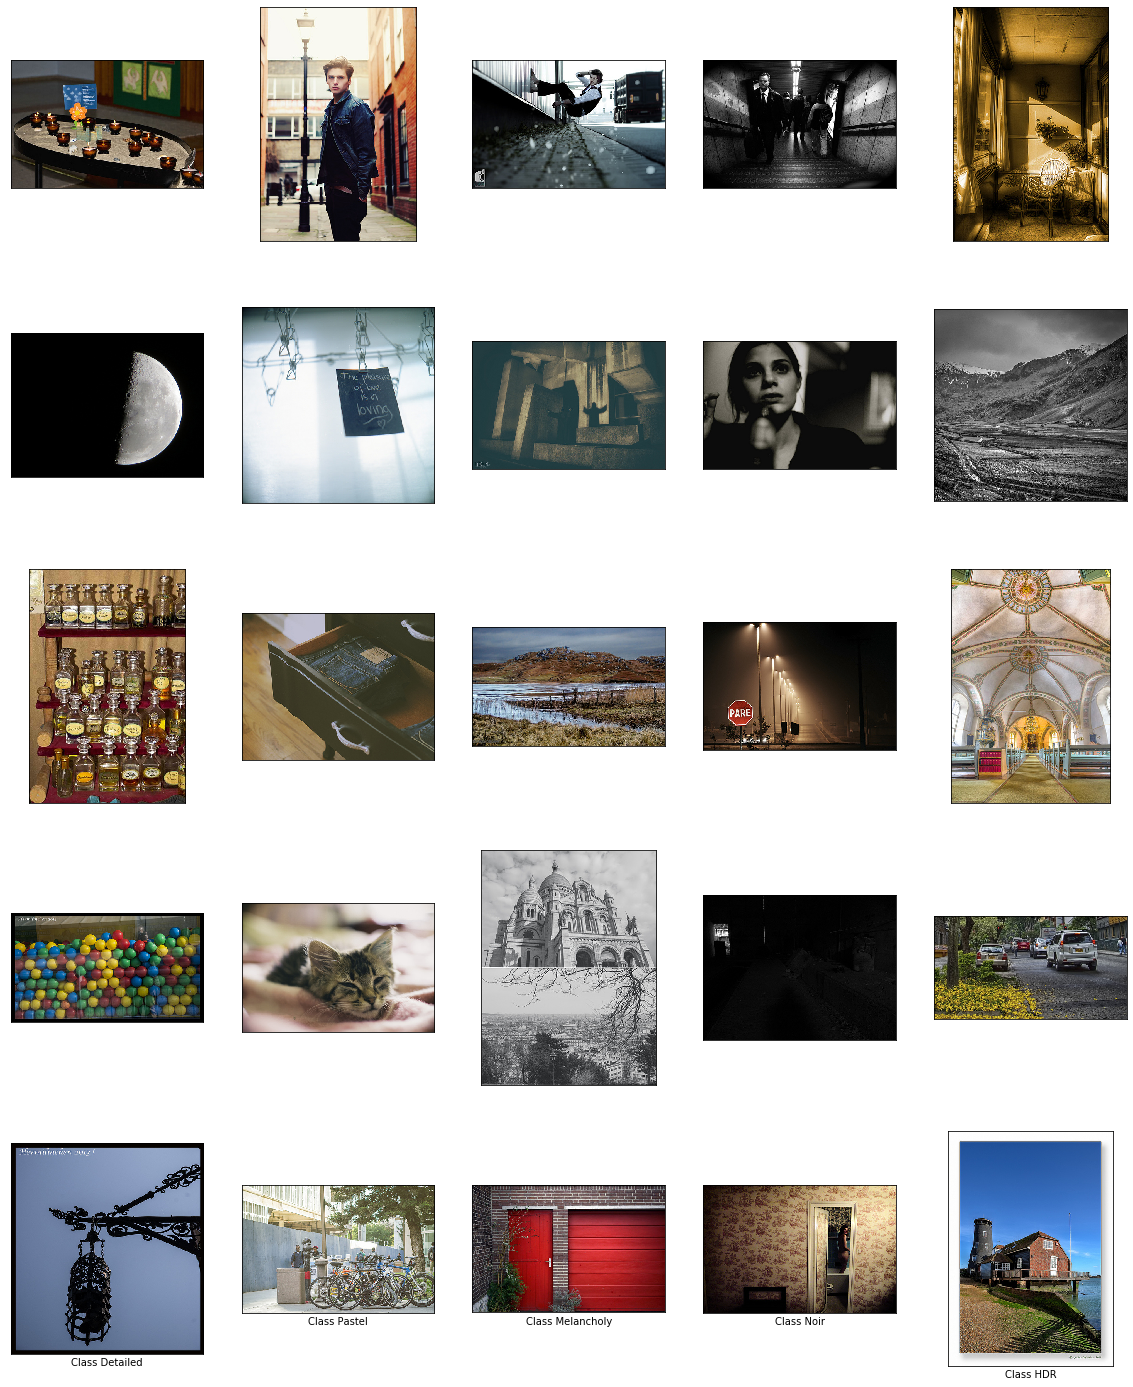

In [22]:
# Mostramos 5 imágenes de cada clase.
plot_n_images = 5
fig = plt.figure(figsize=(20, 25))

np.random.seed(1000)
for i in range(0,STYLE_NUM_LABELS):
    select_frame = train_frame[train_frame['lab_idx']==i]
    for j in range(0,plot_n_images):
        aux_index = np.random.choice(select_frame.index)
        fig_i=fig.add_subplot(plot_n_images,STYLE_NUM_LABELS,j*STYLE_NUM_LABELS+i+1)
        fig_i.imshow(plt.imread(train_frame['files'][aux_index]))
        
        fig_i.set_xticks(())
        fig_i.set_yticks(())
        
    fig_i.set_xlabel('Class %s' % style_labels[i])

<a id="section22"></a>
# <font color="#004D7F" size=5>2.2. Cargando una red pre-entrenada</font>

Existen multitud de estructuras de redes dependiendo del problema y, al revés, existen redes que se pueden utilizar en muchos problemas. 
+ Por ejemplo, en ImageNet, el problema de etiquetado de imágenes, existen diferentes redes como AlexNet, Inception, MobileNet, ResNet, centradas en capas convolucionales y cada una con sus peculiaridades. Sin embargo, estas redes también pueden utilizarse para otros problemas de etiquetado de imágenes como son CIFAR, COCO o Flowers.

La gran cantidad de imagenes de ImageNet ha permitido que se haya convertido en referencia dentro de la investigación en el tratamiento de imágenes y del propio Deep Learning. Es por eso que existen gran cantidad de redes que tratan de resolver este problema y podemos encontrar diferentes implementaciones para casi todas las librerías de Deep Learning y lo que es más importante, los pesos para poder cargar las redes ya entrenadas.

Keras tiene actualmente 20 modelos pre-entrenados con ImageNet en **Applications** que incluyen Inception, ResNet, MobileNet y muchos más. Vamos a utilizar estas funciones para cargar los modelos y realizar los procesos de Transfer Learning.

Lo primero es elegir la red con la que queremos trabajar. En este tutorial vamos a utilizar 2: **MobileNet** y **VGG16**.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
Más información sobre los modelos pre-entrenados con ImageNet en [Applications](https://keras.io/applications/).

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section3"></a>
# <font color="#004D7F" size=6>3. MobileNet</font>

Se trata de una red basada en **Inception** pero optimizada para poder ser ejecutada en dispositivos más limitados como puede ser un teléfono móvil. Aunque sus resultados son algo peores que los de redes más grandes, su reducido tamaño y la velocidad de procesar las imágenes la han convertido en una de las más populares.

<a id="section31"></a>
# <font color="#004D7F" size=5>3.1. Cargar la red</font>

Vamos a ver el proceso para cargar dicha red, ver su estructura y utilizarla para realizar predicciones.

In [23]:
from keras.applications import mobilenet

#Extraemos MobileNet con los weights = imagenet
model = ???

17227776/17225924 [==============================] - 14s 1us/step


In [24]:
#resumimos el modelo cargado
???

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

La estructura está compuesta de 13 bloques _Depthwise Convolution_ y la correspondiente capa Densa de la salida.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
Más información sobre las diferencias de convolución Depthwise con respecto a la convolución normal en este [enlace](https://medium.com/@sagar.tesla/depthwise-separable-convolution-in-caffe-framework-a3a0cf026aee).

<a id="section32"></a>
# <font color="#004D7F" size=5>3.2. Uso de iteradores</font>

Las imágenes tienen de media unos 200KB de tamaño, por lo que las 2K imágenes ocuparán en memoria 400MB. Actualmente, cualquier ordenador puede manejar esta cantidad de información. Sin embargo, trabajar con 80K imágenes a la vez ya si que es inviable.

Es por esto que vamos a utilizar `ImageDataGenerator` y la función `flow_from_dataframe` para crear los iteradores con la base de datos para no tener todo cargado en memoria. Esta función se vio en detalle en la Práctica anterior. Sin embargo, antes de llevar a cabo este proceso, las diferentes redes tienen funciones que preprocesan las imágenes de forma óptima, por lo que una vez carguemos la red, es cuando realizaremos este proceso.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
Más información de interadores en la [documentación de Keras](https://keras.io/preprocessing/image/).

<i class="fa fa-info-circle" aria-hidden="true"></i>
Más información de [preprocess_input](https://keras.io/api/applications/mobilenet/).

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# cuando definimos ImageDataGenerator incluimos los preprocesamientos a realizar
# El procesamiento es propio de mobilenet en el que escala los datos entre -1 y 1
# 
train_datagen = ImageDataGenerator(preprocessing_function = mobilenet.preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function = mobilenet.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function = mobilenet.preprocess_input)

# y con esta indicamos como vamos a leer la información y de donde.
train_iter = train_datagen.flow_from_dataframe(train_frame, 
                                               x_col='files', 
                                               y_col='labels', 
                                               target_size=(224, 224), 
                                               class_mode='categorical',
                                               batch_size=32, 
                                               shuffle=True)


valid_iter = valid_datagen.flow_from_dataframe(valid_frame, 
                                               x_col='files', 
                                               y_col='labels', 
                                               target_size=(224, 224), 
                                               class_mode='categorical',
                                               batch_size=32, 
                                               shuffle=False)

test_iter = test_datagen.flow_from_dataframe(test_frame, 
                                             x_col='files', 
                                             y_col='labels', 
                                             target_size=(224, 224), 
                                             class_mode='categorical',
                                             batch_size=32, 
                                             shuffle=False)

Found 1108 validated image filenames belonging to 5 classes.
Found 277 validated image filenames belonging to 5 classes.
Found 320 validated image filenames belonging to 5 classes.


<a id="section33"></a>
# <font color="#004D7F" size=5>3.3. Predicciones con el modelo base</font>

El modelo cargado ya viene directamente con los pesos entrenados, por lo que ya podemos utilizarla para hacer predicciones de nuestras imágenes. Vamos a ver un ejemplo.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

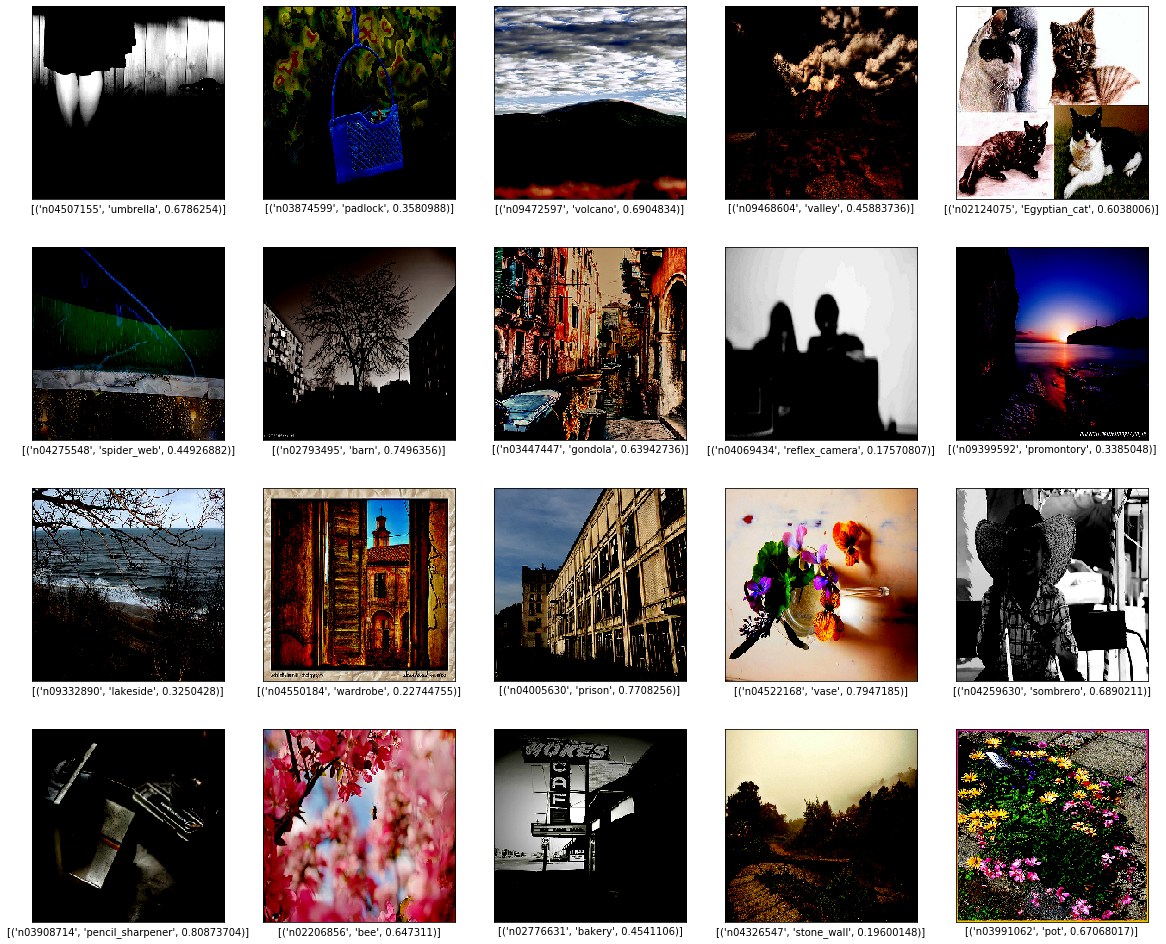

In [27]:
# accedemos al primer batch y nos quedamos solo con las imágenes
test_images = next(test_iter)[0]

# realizamos las predicciones
preds = ???
pred_labels = mobilenet.decode_predictions(preds, top=1)

# Mostramos las 20 imágenes del batch y las etiquetas asignadas por MobileNet.
plot_n_images = 20
fig = plt.figure(figsize=(20, 17))

for i in range(0,5):
    for j in range(0,4):
        counter = i*4+j
        fig_i=fig.add_subplot(4,5,counter+1)
        fig_i.imshow(test_images[counter])

        fig_i.set_xticks(())
        fig_i.set_yticks(())
        
        fig_i.set_xlabel('%s' % ???)

Las imágenes mostradas están ya un tanto distorsionadas porque han sido preprocesadas para MobileNet, aun así, ya podemos observar que acierta algunos de los objetos de las imágenes. Aunque este no sea nuestro objetivo es curioso como es capaz de detectar ciertos elementos incluso en imágenes a las que se le han aplicado modificaciones.

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section4"></a>
# <font color="#004D7F" size=6>4. VGG16</font>

Ahora es el turno de VGG16, al igual que antes, vamos a descargar los pesos aprendidos con ImageNet y ver la estructura de la red. En la siguiente imagen se puede observar también la estructura original.

<img src="img/vgg16.png" width="550">

<a id="section41"></a>
# <font color="#004D7F" size=5>4.1. Cargar la red</font>

Vamos a ver el proceso para cargar dicha red, ver su estructura y utilizarla para realizar predicciones.

In [29]:
???

553467904/553467096 [==============================] - 498s 1us/step


In [30]:
# Imprimir la red
???

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

En este caso, VGG16 está compuesta por 5 bloques de capas convoluciones, finalizando con 2 capas Fully Conected y la softmax de 1000. Esta red es bastante grande, sobre todo en lo que a número de parámetros se refiere. 
 + Si nos fijamos, MobileNet con muchas más capas, solo tiene 4 millones de parámetros, frente a los casi 140 millones de VGG16.

Esta red es también una de las más populares en la literatura, pero su gran tamaño y su bajo rendimiento frente a otras alternativas está haciendo que cada vez sea menos usada. 
+ Sin embargo, para los procesos de extracción de características nos es muy útil por sus capas densas, como más adelante veremos.

<a id="section42"></a>
# <font color="#004D7F" size=5>4.2. Uso de iteradores</font>

Como anteriormente utilizamos iteradores para ver procesar adecuadamente los datos en memoria por batchs.

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# cuando definimos ImageDataGenerator incluimos los preprocesamientos a realizar
train_datagen = ImageDataGenerator(preprocessing_function = vgg16.preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function = vgg16.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function = vgg16.preprocess_input)

# y con esta indicamos como vamos a leer la información y de donde.
train_iter = train_datagen.flow_from_dataframe(train_frame, 
                                               x_col='files', 
                                               y_col='labels', 
                                               target_size=(224, 224), 
                                               class_mode='categorical',
                                               batch_size=32, 
                                               shuffle=True)


valid_iter = valid_datagen.flow_from_dataframe(valid_frame, 
                                               x_col='files', 
                                               y_col='labels', 
                                               target_size=(224, 224), 
                                               class_mode='categorical',
                                               batch_size=32, 
                                               shuffle=False)

test_iter = test_datagen.flow_from_dataframe(test_frame, 
                                             x_col='files', 
                                             y_col='labels', 
                                             target_size=(224, 224), 
                                             class_mode='categorical',
                                             batch_size=32, 
                                             shuffle=False)

Found 1108 validated image filenames belonging to 5 classes.
Found 277 validated image filenames belonging to 5 classes.
Found 320 validated image filenames belonging to 5 classes.


<a id="section43"></a>
# <font color="#004D7F" size=5>4.3. Predicciones con el modelo base</font>

El modelo cargado ya viene directamente con los pesos entrenados, por lo que ya podemos utilizarla para hacer predicciones de nuestras imágenes. 

Vamos a volver a ver que tal clasifica dicha red con algunas de las imágenes de Flickr.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

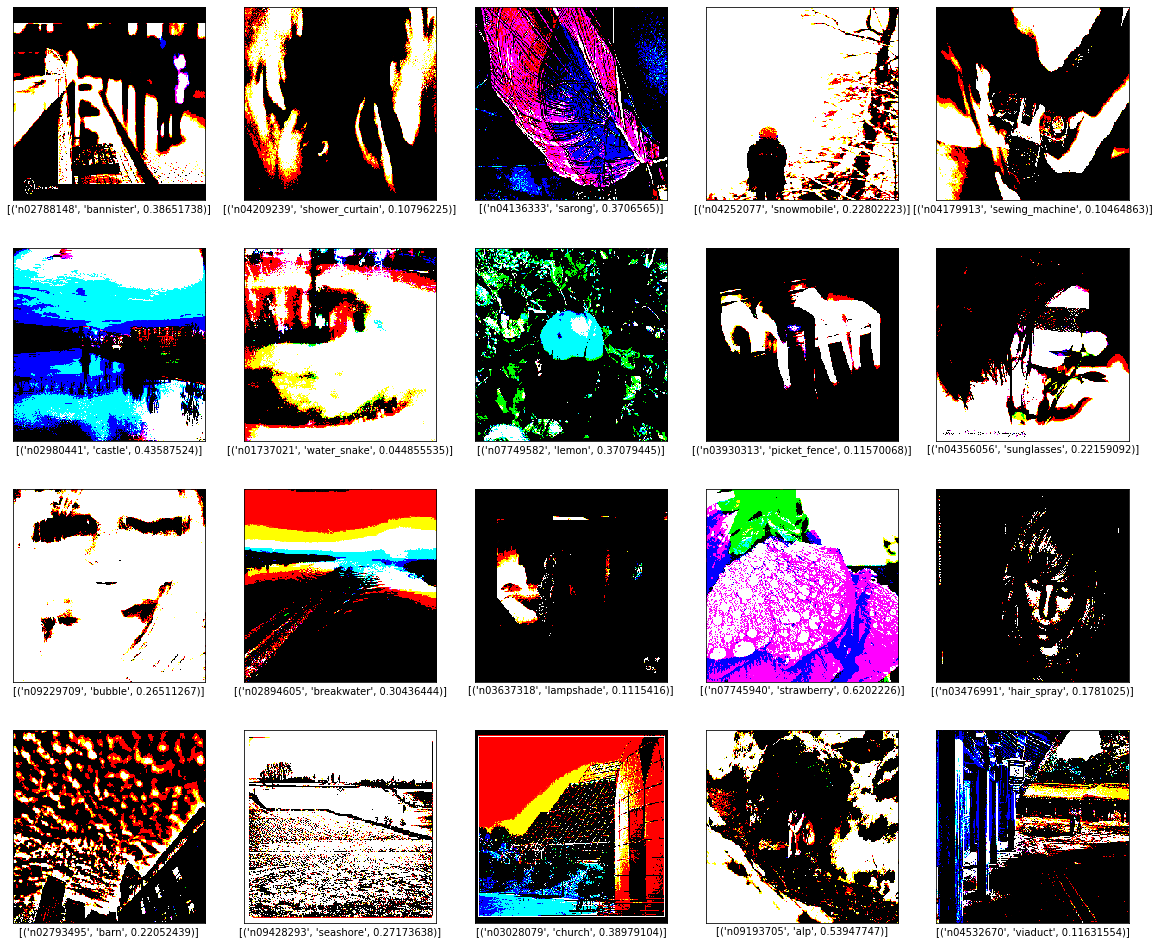

In [32]:
# accedemos al primer batch y nos quedamos solo con las imágenes
test_images = next(test_iter)[0]

# realizamos las predicciones
preds = model.predict(test_images)
pred_labels = vgg16.decode_predictions(preds, top=1)

# Mostramos las 20 imágenes del batch y las etiquetas asignadas por MobileNet.
plot_n_images = 20
fig = plt.figure(figsize=(20, 17))

for i in range(0,5):
    for j in range(0,4):
        counter = i*4+j
        fig_i=fig.add_subplot(4,5,counter+1)
        fig_i.imshow(test_images[counter])

        fig_i.set_xticks(())
        fig_i.set_yticks(())
        
        fig_i.set_xlabel('%s' % pred_labels[counter])

En este caso, las imágenes preprocesadas son incluso menos visibles que antes, pero también hemos obtenido predicciones que podemos comparar con las imágenes más arriba. 

También hay que destacar la importancia del preprocesado, ya que cada red ha sido entrenada aplicando unas modificaciones a las imágenes y esta debe respetarse.

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section6"></a>
# <font color="#004D7F" size=6>6. Finetuning</font>

Ahora es el paso de entrenar las redes. Si recordamos la imagen, en esta etapa vamos a congelar los pesos de las capas inciales y a entrenar sólo la última capa de la red. Se pueden entrenar algunas más dependiendo del problema y del número de imágenes. En este caso, como trabajamos con un subconjunto, no es necesario entrenar más.

<img src="img/finetunning.png" width="450">

Lo más sencillo en estos casos es cargar la red en la que vamos a realizar el finetuning, MobileNet en este ejemplo, de la misma forma que hemos hecho en los casos anteriores, y añadir las capas nuevas que queremos aprender a nuestro grafo. Lo que vamos a hacer es crear una nueva última capa Softmax pero esta vez con las 5 clases de nuestro problema, y esa capa recibirá la salida de `global_average_pooling2d_1`.

<a id="section61"></a>
# <font color="#004D7F" size=5>6.1. Cargar la red</font>

Vamos a ver el proceso para cargar dicha red, ver su estructura y utilizarla para realizar predicciones.

Los modelos de Keras ya vienen preparado para este proceso de finetuning. Cuando creamos un objeto de cualquier modelo tenemos la opción de `include_top`, que en el caso de ser **False** elimina las últimas capas de la red, para poder incluir nuestras modificaciones.

En el caso de querer modificar más capas, es posible con la función `pop()`, que va quitando capas empezando por el final.

Vamos a ver un ejemplo de todo esto y a ver las nuevas redes con `summary`.

In [40]:
# cargamos el modelo base
base_model = ???

# y congelamos el entrenamiento en todas las capas
for layer in base_model.layers:
    ???

17227776/17225924 [==============================] - 14s 1us/step


In [41]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

<a id="section62"></a>
# <font color="#004D7F" size=5>6.2. Añadir capas a la red</font>

Una vez cargada la red podemos añadir diferentes capas a la red tal y como sean nuestras necesidades. 

En este ejemplo vamos a añadir una capa Dropout y una Densa de salida con las 5 posibles clases que tenemos.

In [42]:
from keras.layers import Dropout, Dense
from keras.models import Model

x = ???
x = ???

model = ???

In [43]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

Si nos fijamos en la última capa tenemos parámetros que no están entrenados. Esto es normal ya que es una capa que hemos añadido y tenemos que realizar un entrenamiento para ajustarlos.

<a id="section63"></a>
# <font color="#004D7F" size=5>6.3. Uso de iteradores</font>

Como siempre, hay que preparar los iteradores

In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# cuando definimos ImageDataGenerator incluimos los preprocesamientos a realizar
train_datagen = ImageDataGenerator(preprocessing_function = mobilenet.preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function = mobilenet.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function = mobilenet.preprocess_input)

# y con esta indicamos como vamos a leer la información y de donde.
train_iter = train_datagen.flow_from_dataframe(train_frame, 
                                               x_col='files', 
                                               y_col='labels', 
                                               target_size=(224, 224), 
                                               class_mode='categorical',
                                               batch_size=32, 
                                               shuffle=True)


valid_iter = valid_datagen.flow_from_dataframe(valid_frame, 
                                               x_col='files', 
                                               y_col='labels', 
                                               target_size=(224, 224), 
                                               class_mode='categorical',
                                               batch_size=32, 
                                               shuffle=False)

test_iter = test_datagen.flow_from_dataframe(test_frame, 
                                             x_col='files', 
                                             y_col='labels', 
                                             target_size=(224, 224), 
                                             class_mode='categorical',
                                             batch_size=32, 
                                             shuffle=False)

Found 1108 validated image filenames belonging to 5 classes.
Found 277 validated image filenames belonging to 5 classes.
Found 320 validated image filenames belonging to 5 classes.


<a id="section64"></a>
# <font color="#004D7F" size=5>6.4. Actualización de pesos</font>

Con esto, ya hemos creado una nueva red con la estructura y pesos de MobileNet para el problema de ImageNet, pero hemos modificado la salida para que se adapte a nuestro problema y vamos a realizar el finetuning para ajustar los pesos de esta última capa.

In [24]:
from keras.optimizers import SGD

sgd = ???
model.compile(???)

history = ???

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
34/34 [==============================] - 9s 276ms/step - loss: 3.0030 - acc: 0.2555 - val_loss: 1.3302 - val_acc: 0.4766
Epoch 2/10
34/34 [==============================] - 7s 202ms/step - loss: 2.2185 - acc: 0.3690 - val_loss: 1.1273 - val_acc: 0.5633
Epoch 3/10
34/34 [==============================] - 7s 200ms/step - loss: 1.9659 - acc: 0.4219 - val_loss: 1.0343 - val_acc: 0.6204
Epoch 4/10
34/34 [==============================] - 7s 206ms/step - loss: 1.8083 - acc: 0.4484 - val_loss: 1.0545 - val_acc: 0.6000
Epoch 5/10
34/34 [==============================] - 7s 203ms/step - loss: 1.5837 - acc: 0.4702 - val_loss: 0.9748 - val_acc: 0.6571
Epoch 6/10
34/34 [==============================] - 7s 209ms/step - loss: 1.6102 - acc: 0.4753 - val_loss: 0.9447 - val_acc: 0.6531
Epoch 7/10
34/34 [==============================] - 7s 201ms/step - loss: 1.5022 - acc: 0.4884 - val_loss: 0.9157 - val_acc: 0.6816
Epoch 8/10
34/34 [==========

<a id="section65"></a>
# <font color="#004D7F" size=5>6.5. Resultados del modelo</font>

Finalmente, una vez ajustados los pesos y entrenado el modelo modificado podemos ver los resultados

In [25]:
score = ???
print("loss en validación: {} \naccuracy en validación: {}".format(score[0],score[1]))
score = ???
print("loss en test: {} \naccuracy en test: {}".format(score[0],score[1]))

loss en validación: 0.9743180046276171 
accuracy en validación: 0.6571428572644993
loss en test: 1.1789556622505188 
accuracy en test: 0.5625


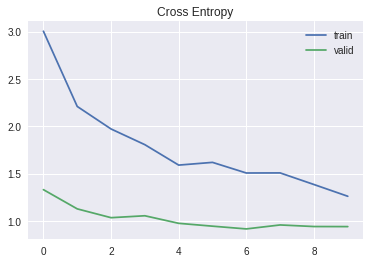

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','valid'])
plt.title('Cross Entropy')
plt.show()

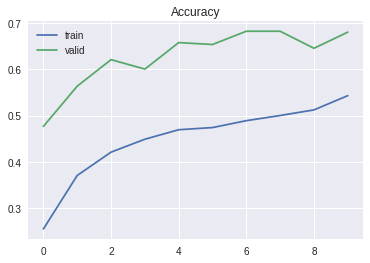

In [27]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train','valid'])
plt.title('Accuracy')
plt.show()

---

<h3><font color="#004D7F" size=5> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i> Ejercicio</font></h3>

Hemos obtenido muy buenos resultados del finetuning en MobileNet. Como se ha comentado, es una red muy sencilla pensada para móvil, por eso, se propone el uso de finetuning en otras redes de Keras, especialmente Inception y ResNet. También podéis ver como afectan los optimizadores como Adam o el proceso de finetuning de más capas.

In [0]:
# TODO

<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#004D7F"></i> </font></div>